<a href="https://colab.research.google.com/github/MLGlobalHealth/StatML4PopHealth/blob/main/lectures/day3/hsgp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Scalable Gaussian Process Regression with Stan

## Objectives
In this practical, you will learn about how to implement an fast and scalable Gaussian Process (GP) approximation in Stan. More specificially, this practical will teach you how to implement the Hilbert space approximate Gaussian process (HSGP) proposed by Arno Solin and Simo Sarkkar in 2020 [1] and picked up by Riutort-Mayol et al. (2022) [2] for use in probabilistic programming frameworks such as Stan.

1. Arno Solin and Simo Sarkka (2020). Hilber space methods for reduced-rank Gaussian process regression. *Statistics and Computing*.
2. Gabriel Riutort-Mayol et al. (2022), Practical Hilbert space approximate Gaussian processes for probabilistic programming. *Statistics and Computing*.

By the end of this practical,
1. You will have a better understanding of implementing custom functions in Stan;
2. You will improve your ability to translate mathematics into Stan code;
3. You will have a better understanding of HSGP and its implementation in Stan.

## Flow of the practical
1. Review of Hilbert Space approximate Gaussian Processes
2. How to implement HSGP in Stan
3. An application of GPs for causal inference

In [1]:
# Install CmdStanPy for Google Colab
!curl -O "https://raw.githubusercontent.com/MLGlobalHealth/StatML4PopHealth/main/practicals/resources/scripts/utilities.py"
from utilities import custom_install_cmdstan, test_cmdstan_installation
custom_install_cmdstan()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2066  100  2066    0     0   4821      0 --:--:-- --:--:-- --:--:--  4815
Installing cmdstanpy==1.2.5
Unpacking colab-cmdstan-2.36.0.tar.gz
Installing required libtbb2 Linux package
Setting cmdstan path
CmdStan successfully installed!


In [2]:
import numpy as np
import pandas as pd

from cmdstanpy import CmdStanModel
import arviz as az

import matplotlib.pyplot as plt
import seaborn as sns

# Visualisation defaults
sns.set_theme(style='whitegrid')
plt.rc('font', size=9)          # controls default text sizes
plt.rc('axes', titlesize=10)    # fontsize of the axes title
plt.rc('axes', labelsize=9)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=9)    # fontsize of the tick labels
plt.rc('ytick', labelsize=9)    # fontsize of the tick labels
plt.rc('legend', fontsize=9)    # legend fontsize

## The dataset
For this tutorial, we will use the `nile` dataset available via the `statsmodels` library. The dataset consists of annual flow measurements of the Nile River at Aswan from 1871 to 1970.

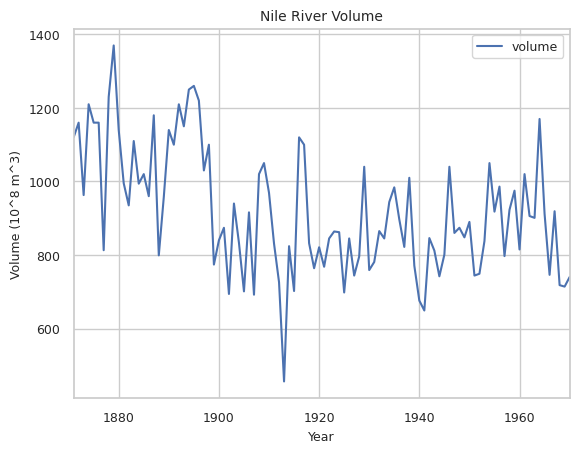

In [3]:
from statsmodels.datasets import nile
nile = nile.load_pandas().data

# Plot the data
fig, ax = plt.subplots()
nile.plot(x='year', y='volume', ax=ax)
ax.set_title('Nile River Volume')
ax.set_xlabel('Year')
ax.set_ylabel('Volume (10^8 m^3)')
ax.set_xlim(1871, 1970)
plt.show()

### Data preprocessing
To make things easier for the model, we will normalise the year data to be between 0 and 1 and standardise the flow data to have a mean of 0 and a standard deviation of 1.

In [4]:
volume = nile['volume'].values
year = nile['year'].values

# Standardise year
year_mean = year.mean()
year_std = year.std()
x = (year - year_mean) / year_std

# Standardise volume
volume_mean = volume.mean()
volume_std = volume.std()
y = (volume - volume_mean) / volume_std

print(x.shape, y.shape)

(100,) (100,)


## Review of Hilbert Space approximate Gaussian Processes

Solin and Sarkka (2020) proposed to approximate stationary kernels as a truncated sum of the spectral density of the kernel evaluated at the square root of specific eigenvalues multiplied by the corresponding eigenvectors:
$$
k(x,x') \approx \sum_{m=1}^M S_\theta(\sqrt{\lambda_m}) \phi_m(x) \phi_m(x'),
$$
where $S_\theta$ is the spectral density of the kernel, $\lambda_m$ are the eigenvalues, and $\phi_m$ are the eigenvectors. The number of terms $M$ is a hyperparameter that controls the approximation accuracy.

Here, the eigenvalues and eigenvectors are given as,
$$
\lambda_m = \left( \frac{n\pi}{2L} \right)^2, \quad \phi_m(x) = \sqrt{\frac1L} \sin\left(\sqrt{\lambda_m}(x + L)\right).
$$
Here $L$ is a boundary condition which determines the size of the domain in which the GP is approximated.

The expression for the spectral density depends on the kernel. Here are 3 of the most commonly used stationary kernels and their spectral densities:

1. Squared exponential kernel:
$$
S_{\sigma,\ell}(\omega) = \sigma^2 \sqrt{2\pi} \ell \exp\left(-\frac{\ell^2\omega^2}{2}\right).
$$
2. Matern 3/2 kernel:
$$
S_{\sigma,\ell}(\omega) = \sigma^2 \frac{2\sqrt{3}}{\ell} \left(\frac{3}{\ell^2} + \omega^2 \right)^{-2}.
$$
3. Matern 5/2 kernel:
$$
S_{\sigma,\ell}(\omega) = \sigma^2 \frac{8\sqrt{5}}{3\ell} \left(\frac{5}{\ell^2} + \omega^2 \right)^{-5/2}.
$$

We can rewrite the truncated sum in matrix notation as
$$
k(x,x') \approx \mathbf{\phi}(x)^\top \mathbf{\Delta} \mathbf{\phi}(x'),
$$
where $\mathbf{\phi}(x) = \{ \phi_m(x) \}_{m=1}^M \in \mathbb{R}^M$ are the eigenvectors evaluated at the input point, and $\mathbf{\Delta} = \text{diag}(\{ S_\theta(\sqrt{\lambda_m}) \}_{m=1}^M) \in \mathbb{R}^{M \times M}$ is a diagonal matrix of the spectral density evaluated at the square root of the eigenvalues.

Then, the covariance matrix $\mathbf{K}$ can be approximated as
$$
\mathbf{K} \approx \tilde{\mathbf{K}} = \mathbf{\Phi} \mathbf{\Delta} \mathbf{\Phi}^\top,
$$
where
$$
\mathbf{\Phi} = \begin{pmatrix}
\phi_1(x_1) & \cdots & \phi_M(x_1) \\
\vdots & \ddots & \vdots \\
\phi_1(x_n) & \cdots & \phi_M(x_n)
\end{pmatrix}
$$
is a matrix of the eigenvectors. From this we have that the GP sample can be approximated as
$$
\mathbf{f} \approx \tilde{\mathbf{f}} \sim N(\mathbf{0}, \tilde{\mathbf{K}}).
$$
We can sample from the approximate GP by first sampling an auxiliary vector $\mathbf{z} \sim N(\mathbf{0}, \mathbf{I}_M)$ and then computing the approximate GP sample as
$$
\tilde{\mathbf{f}} = \mathbf{\Phi} \mathbf{\Delta}^{1/2} \mathbf{z}
$$
where $\mathbf{\Delta}^{1/2}$ is the square root of the diagonal matrix $\mathbf{\Delta}$:
$$
\mathbf{\Delta}^{1/2} = \begin{pmatrix}
S_\theta(\sqrt{\lambda_1})^{1/2} & & \\
& \ddots & \\
& & S_\theta(\sqrt{\lambda_M})^{1/2}
\end{pmatrix}.
$$

<details>
<summary>Click to see the proof</summary>

Let $\tilde{\mathbf{L}} = \mathbf{\Phi} \mathbf{\Delta}^{1/2}$. Then, we have that
$$
\tilde{\mathbf{K}} = \mathbf{\Phi}^\top \mathbf{\Delta} \mathbf{\Phi} = \tilde{\mathbf{L}} \tilde{\mathbf{L}}^\top.
$$
Let $\mathbf{z} \sim N(\mathbf{0}, \mathbf{I}_M)$. Then, we have that
$$
\mathbb{E}[\mathbf{z}] = \mathbf{0}
$$
and
$$
\mathbb{E}[\tilde{\mathbf{L}} \mathbf{z}] = \mathbf{\Phi} \mathbf{\Delta}^{1/2} \mathbb{E}[\mathbf{z}] = \mathbf{0}.
$$
Thus, $\tilde{\mathbf{L}} \mathbf{z}$ has zero mean. The covariance matrix of $\tilde{\mathbf{L}} \mathbf{z}$ is
$$
\text{Cov}(\tilde{\mathbf{L}} \mathbf{z})
= \mathbb{E}[(\tilde{\mathbf{L}} \mathbf{z}) (\tilde{\mathbf{L}}\mathbf{z})^\top] = \tilde{\mathbf{L}}\mathbb{E}[ \mathbf{z} \mathbf{z}^\top]\tilde{\mathbf{L}}^\top.
$$
Since $\mathbf{z} \sim N(\mathbf{0}, \mathbf{I}_M)$, we have that
$$
\mathbb{E}[\mathbf{z} \mathbf{z}^\top] = \mathbf{I}_M.
$$
Thus,
$$
\text{Cov}(\tilde{\mathbf{L}} \mathbf{z}) = \tilde{\mathbf{L}}\tilde{\mathbf{L}}^\top = \tilde{\mathbf{K}}.
$$
This confirms that $\tilde{\mathbf{f}} \sim N(\mathbf{0}, \tilde{\mathbf{K}})$ and concludes the proof.

</details>


### The boundary condition
HSGP is an approximation of a Gaussian process on a compact subspace of the real line $S \subset \mathbb{R}$. We are going to assume that our input points are centered around 0 and we are going to define our subspace as $[-L, L]$ where
$$
L = C \times \max(\mathbf{x}).
$$
We refer to $C$ as the boundary inflation factor and for this tutorial set $C = 1.5$.

## The model

Let $\mathbf{y} = (y_1,\ldots,y_n)^\top$ be a vector of outcomes, in this case flow volume. Let $\mathbf{x} = (x_1,\ldots,x_n)^\top$ be a vector of inputs, in this case year. We will model the data as
$$
\begin{align*}
\mathbf{y} &= \alpha + \tilde{f}(\mathbf{x}) + \boldsymbol{\varepsilon}, \\
\boldsymbol{\varepsilon} &\sim N(0, \sigma_{\varepsilon}^2\mathbf{I}_n), \\
\tilde{f}(\mathbf{x}) &\sim \text{HSGP}(\mathbf{x}; \mathbf{z}, \sigma, \ell), \\
\alpha &\sim N(0, 10), \\
\boldsymbol{z} &\sim N(0, \mathbf{I}_M), \\
\sigma &\sim \text{inv-Gamma}(5, 5) \\
\ell &\sim \text{inv-Gamma}(5, 5) \\
\sigma_{\varepsilon} &\sim \text{inv-Gamma}(5,5)
\end{align*}
$$


## Implementing HSGP in Stan

We will work in a new Stan file: call it `hsgp_regression.stan`. The Stan program will be similar in structure to the GP program, but with a few modifications. We will begin by implementing functions to construct the spectral densities, eigenvalues, and eigenvectors. We will put them together to define a functions named `hsgp_se`, `hsgp_matern32`, and `hsgp_matern52`, that take in the input points `x`, the hyperparameters `sigma` and `ell`, a matrix of eigenvectors `PHI`, and a vector of auxiliary variables `z`. The function will return the HSGP sample `f`.

### Spectral density functions

Let us start by defining the spectral densities. We will define three functions: `spd_se`, `spd_matern32`, and `spd_matern52`. These functions will take as input a vector of frequencies `omega` and the hyperparameters `sigma` and `ell`. The functions will return the spectral density evaluated at the frequencies.

```stan
functions {
	vector spd_se(vector omega, real sigma, real ell) {
		// Implement the spectral density for the squared exponential kernel
	}

	vector spd_matern32(vector omega, real sigma, real ell) {
		// Implement the spectral density for the Matern 3/2 kernel
	}

	vector spd_matern52(vector omega, real sigma, real ell) {
		// Implement the spectral density for the Matern 5/2 kernel
	}
}
```

### Eigenvalues and eigenvector functions
Next, we will implement functions to compute the eigenvalues and eigenvectors. We will define two functions: `eigenvalues` and `eigenvectors`. The `eigenvalues` function will take in the number basis functions `M` and the boundary condition `L` and return a vector of eigenvalues. The `eigenvectors` function will take in the input points `x`, the number of basis functions `M`, the boundary condition `L`, and the eigenvalues `lambda` and return a matrix of eigenvectors.

```stan
functions {
	// Other functions...

	vector eigenvalues(int M, real L) {
		// Implement the eigenvalues function
	}

	matrix eigenvectors(vector x, int M, real L, vector lambda) {
		// Implement the eigenvectors function
	}
}
```

### HSGP function
Finally, we put these components together to define the `hsgp` function. The function will take in the input points `x`, the hyperparameters `sigma` and `ell`, the eigenvector matrix `PHI`, and a vector of auxiliary variables `z`. The function will return a vector of the HSGP sample `f`.

```stan
functions {
	// Other functions...

	vector hsgp_se(vector x, real sigma, real ell, vector lambdas, matrix PHI, vector z) {
		int n = rows(x);
		int M = cols(PHI);
		vector[n] f;
		matrix[M, M] Delta;

		// Implement the HSGP function
		// 1. Compute the spectral densities

		// 2. Construct the diagonal matrix Delta

		// 3. Compute the HSGP sample

		return f;
	}

	vector hsgp_matern32(vector x, real sigma, real ell, matrix PHI, vector z) {
		// Implement the HSGP function
	}

	vector hsgp_matern52(vector x, real sigma, real ell, matrix PHI, vector z) {
		// Implement the HSGP function
	}
}
```

### Data block
We will need to define the data block to include the number of data points `N` (positive integer), the input points `x` (vector of length `N`), the outcome `y` (real valued array of length `N`), the boundary inflation constant `C` (positive real value), and the number of eigenfunctions `M` (positive integer).

### Transformed data block
In the transformed data block:
1. Define the boundary condition `L` as `C * max(x)`
2. Precompute the eigenvalues `lambda` and the eigenvectors `PHI` using the `eigenvalues` and `eigenvectors` functions.

### Parameters block
In the parameters block define:
1. The interecpt `alpha` (real value)
2. The noise standard deviation `sigma_eps` (positive real value)
3. vector of standard normal random variables `z`
4. The marginal GP variance `sigma` (positive real)
5. The GP lengthscale `ell` (positive real)

### Transformed parameters block
In the transformed parameters block, implement
1. `f`: a vector of size `N` which is an approximate sample of a GP with the squared exponential kernel.
2. `mu`: a vector of size `N` that contains the expected value of `y` at each input point.

### Model block
In the model block we assign priors to all the parameters defined in the parameters block and we define the likelihood.

### Generated quantities block
Finally, in the generated quatities block you compute the log likelihood `log_lik` for each data point as well as generate random samples `y_rep` based on the inferred parameters of the model.

Compile the Stan code using the `CmdStanModel` class from the `cmdstanpy` library.

In [33]:
hsgp_se_model = CmdStanModel(stan_file='hsgp_regression.stan')

DEBUG:cmdstanpy:Removing /content/hsgp_regression
21:20:10 - cmdstanpy - INFO - compiling stan file /content/hsgp_regression.stan to exe file /content/hsgp_regression
INFO:cmdstanpy:compiling stan file /content/hsgp_regression.stan to exe file /content/hsgp_regression
DEBUG:cmdstanpy:cmd: make STANCFLAGS+=--filename-in-msg=hsgp_regression.stan /content/hsgp_regression
cwd: cmdstan-2.36.0
DEBUG:cmdstanpy:Console output:

--- Translating Stan model to C++ code ---
bin/stanc --filename-in-msg=hsgp_regression.stan --o=/content/hsgp_regression.hpp /content/hsgp_regression.stan

--- Compiling C++ code ---
g++ -std=c++17 -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes -Wno-class-memaccess      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I stan/lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.4.0 -I stan/lib/stan_math/lib/boost_1.84.0 -I stan/lib/stan_math/lib/sundials_6.1.1/include -I stan/lib/stan_ma

Create the stan data dictionary with the number of data points `N`, the input points `x`, the output points `y`, the number of basis functions `M`, the boundary inflation factor `C`, and the number of eigenvectors `M`.

In [26]:
stan_data = {
	'N': len(x),
	'x': x,
	'y': y,
	'C': 1.5,
	'M': 30
}

Run the MCMC algorithm with 4 chains, 500 warmup iterations, and 1000 iterations. Set the `adapt_delta` argument to 0.95 and set the random seed.

In [27]:
import time
start_time = time.time()

hsgp_se_fit = hsgp_se_model.sample(
	data=stan_data,
	chains=4,
	iter_warmup=500,
	iter_sampling=1000,
	adapt_delta=0.95,
	seed=0
)

end_time = time.time()
runtime = end_time - start_time
print(f"Runtime of the Stan model: {runtime} seconds")

DEBUG:cmdstanpy:cmd: /content/hsgp_regression info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcytd9m2n/3je4mtue.json
21:16:46 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/hsgp_regression', 'id=1', 'random', 'seed=0', 'data', 'file=/tmp/tmpcytd9m2n/3je4mtue.json', 'output', 'file=/tmp/tmpcytd9m2n/hsgp_regressionik8dsg1b/hsgp_regression-20250325211646_1.csv', 'method=sample', 'num_samples=1000', 'num_warmup=500', 'algorithm=hmc', 'adapt', 'engaged=1', 'delta=0.95']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/hsgp_regression', 'id=2', 'random', 'seed=0', 'data', 'file=/tmp/tmpcytd9m2n/3je4mtue.json', 'output', 'file=/tmp/tmpcytd9m2n/hsgp_regressionik8dsg1b/hsgp_regression-20250325211646_2.csv', 'method=sample', 'num_samples=1000', 'num_warmup=500', 'algorithm=hmc', 'adapt', 'engaged=1', 'delta=0.95']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/hsgp_regression', 'id=3', 'random', 'seed=0', 'data', 'file=/tmp/tmpcytd9

21:19:24 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/hsgp_regression', 'id=1', 'random', 'seed=0', 'data', 'file=/tmp/tmpcytd9m2n/3je4mtue.json', 'output', 'file=/tmp/tmpcytd9m2n/hsgp_regressionik8dsg1b/hsgp_regression-20250325211646_1.csv', 'method=sample', 'num_samples=1000', 'num_warmup=500', 'algorithm=hmc', 'adapt', 'engaged=1', 'delta=0.95']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpcytd9m2n/hsgp_regressionik8dsg1b/hsgp_regression-20250325211646_1.csv
 console_msgs (if any):
	/tmp/tmpcytd9m2n/hsgp_regressionik8dsg1b/hsgp_regression-20250325211646_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 1000 (Default)
    num_warmup = 500
    save_warmup = false (Default)
    thin = 1 (Default)
    adapt
      engaged = true (Default)
      ga


Runtime of the Stan model: 158.10512828826904 seconds


In [28]:
print(hsgp_se_fit.diagnose())

DEBUG:cmdstanpy:cmd: cmdstan-2.36.0/bin/diagnose /tmp/tmpcytd9m2n/hsgp_regressionik8dsg1b/hsgp_regression-20250325211646_1.csv /tmp/tmpcytd9m2n/hsgp_regressionik8dsg1b/hsgp_regression-20250325211646_2.csv /tmp/tmpcytd9m2n/hsgp_regressionik8dsg1b/hsgp_regression-20250325211646_3.csv /tmp/tmpcytd9m2n/hsgp_regressionik8dsg1b/hsgp_regression-20250325211646_4.csv
cwd: None


Checking sampler transitions treedepth.
3 of 1000 (0.30%) transitions hit the maximum treedepth limit of 10, or 2^10 leapfrog steps.
Trajectories that are prematurely terminated due to this limit will result in slow exploration.
For optimal performance, increase this limit.

Checking sampler transitions for divergences.
116 of 1000 (11.60%) transitions ended with a divergence.
These divergent transitions indicate that HMC is not fully able to explore the posterior distribution.
Try increasing adapt delta closer to 1.
If this doesn't remove all divergences, try to reparameterize the model.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Rank-normalized split effective sample size satisfactory for all parameters.

Rank-normalized split R-hat values satisfactory for all parameters.

Processing complete.



In [29]:
custom_summary_fns = {
    'median': lambda x: np.median(x),
    'q2.5': lambda x: np.percentile(x, 2.5),
    'q97.5': lambda x: np.percentile(x, 97.5)
}

In [30]:
idata_hsgp_se = az.from_cmdstanpy(hsgp_se_fit)
mu_hsgp_se_sum = az.summary(idata_hsgp_se, var_names=['mu'], stat_funcs=custom_summary_fns, extend=False)
y_rep_hsgp_se_sum = az.summary(idata_hsgp_se, var_names=['y_rep'], stat_funcs=custom_summary_fns, extend=False)

In [31]:
# Function that plots the posterior summary against the observed data
def plot_posterior_summary(year, y, posterior_summary):
	fig, ax = plt.subplots()
	ax.scatter(year, y, label='Data', s=10)
	ax.plot(year, posterior_summary['median'], label='Posterior Median of f', color='red')
	ax.fill_between(year, posterior_summary['q2.5'], posterior_summary['q97.5'], color='gray', alpha=0.2, label='95% CI')
	ax.set_title('Posterior Median of f vs Data')
	ax.set_xlabel('Year')
	ax.set_ylabel('Volume (10^8 m^3)')
	ax.set_xlim(1871, 1970)
	ax.legend()
	plt.show()

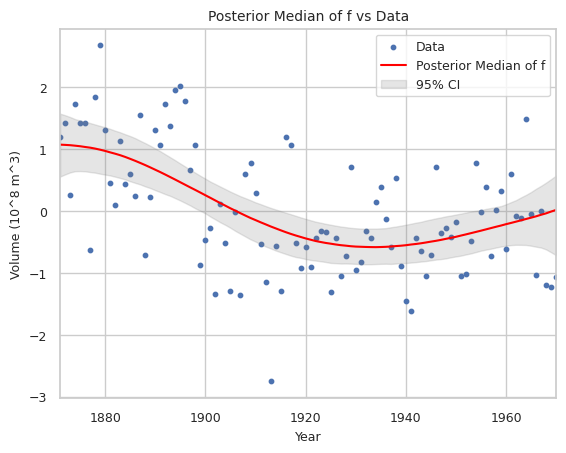

In [32]:
plot_posterior_summary(year, y, mu_hsgp_se_sum)

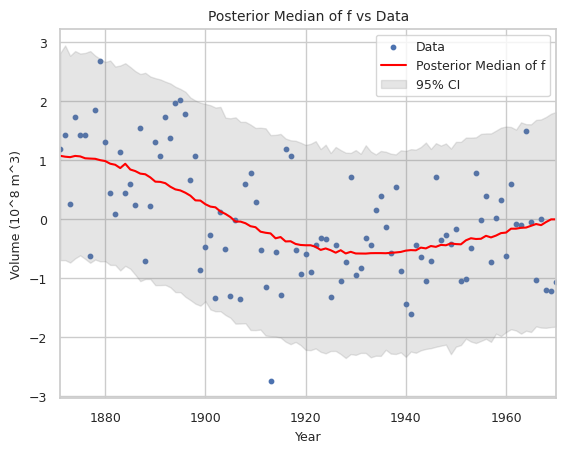

In [34]:
plot_posterior_summary(year, y, y_rep_hsgp_se_sum)

Create a new Stan file titled `hsgp_matern32_regression.stan` where the squared exponential covariance kernel is replaced by the Matern 3/2 kernel.

In [35]:
hsgp_matern32_model = CmdStanModel(stan_file='hsgp_matern32_regression.stan')

21:25:36 - cmdstanpy - INFO - compiling stan file /content/hsgp_matern32_regression.stan to exe file /content/hsgp_matern32_regression
INFO:cmdstanpy:compiling stan file /content/hsgp_matern32_regression.stan to exe file /content/hsgp_matern32_regression
DEBUG:cmdstanpy:cmd: make STANCFLAGS+=--filename-in-msg=hsgp_matern32_regression.stan /content/hsgp_matern32_regression
cwd: cmdstan-2.36.0
DEBUG:cmdstanpy:Console output:

--- Translating Stan model to C++ code ---
bin/stanc --filename-in-msg=hsgp_matern32_regression.stan --o=/content/hsgp_matern32_regression.hpp /content/hsgp_matern32_regression.stan

--- Compiling C++ code ---
g++ -std=c++17 -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes -Wno-class-memaccess      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I stan/lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.4.0 -I stan/lib/stan_math/lib/boost_1.84.0 -I stan/lib/stan_math/lib/sundials_6.

In [36]:
hsgp_matern32_fit = hsgp_matern32_model.sample(
	data=stan_data,
	chains=4,
	iter_warmup=500,
	iter_sampling=1000,
	adapt_delta=0.95,
	seed=0
)

DEBUG:cmdstanpy:cmd: /content/hsgp_matern32_regression info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcytd9m2n/93cnqnjy.json
21:26:38 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/hsgp_matern32_regression', 'id=1', 'random', 'seed=0', 'data', 'file=/tmp/tmpcytd9m2n/93cnqnjy.json', 'output', 'file=/tmp/tmpcytd9m2n/hsgp_matern32_regression19_2sdw6/hsgp_matern32_regression-20250325212638_1.csv', 'method=sample', 'num_samples=1000', 'num_warmup=500', 'algorithm=hmc', 'adapt', 'engaged=1', 'delta=0.95']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/hsgp_matern32_regression', 'id=2', 'random', 'seed=0', 'data', 'file=/tmp/tmpcytd9m2n/93cnqnjy.json', 'output', 'file=/tmp/tmpcytd9m2n/hsgp_matern32_regression19_2sdw6/hsgp_matern32_regression-20250325212638_2.csv', 'method=sample', 'num_samples=1000', 'num_warmup=500', 'algorithm=hmc', 'adapt', 'engaged=1', 'delta=0.95']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/hsgp_matern32_regre

21:27:22 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/hsgp_matern32_regression', 'id=1', 'random', 'seed=0', 'data', 'file=/tmp/tmpcytd9m2n/93cnqnjy.json', 'output', 'file=/tmp/tmpcytd9m2n/hsgp_matern32_regression19_2sdw6/hsgp_matern32_regression-20250325212638_1.csv', 'method=sample', 'num_samples=1000', 'num_warmup=500', 'algorithm=hmc', 'adapt', 'engaged=1', 'delta=0.95']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpcytd9m2n/hsgp_matern32_regression19_2sdw6/hsgp_matern32_regression-20250325212638_1.csv
 console_msgs (if any):
	/tmp/tmpcytd9m2n/hsgp_matern32_regression19_2sdw6/hsgp_matern32_regression-20250325212638_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 1000 (Default)
    num_warmup = 500
    save_warmup = false (Default)
    thin 

21:27:23 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 1 divergent transitions (0.1%)
	Chain 2 had 2 divergent transitions (0.2%)
	Chain 4 had 1 divergent transitions (0.1%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.
	Chain 1 had 1 divergent transitions (0.1%)
	Chain 2 had 2 divergent transitions (0.2%)
	Chain 4 had 1 divergent transitions (0.1%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


In [37]:
idata_hsgp_matern32 = az.from_cmdstanpy(hsgp_matern32_fit)
mu_hsgp_matern32_sum = az.summary(idata_hsgp_matern32, var_names=['mu'], stat_funcs=custom_summary_fns, extend=False)
y_rep_hsgp_matern32_sum = az.summary(idata_hsgp_matern32, var_names=['y_rep'], stat_funcs=custom_summary_fns, extend=False)

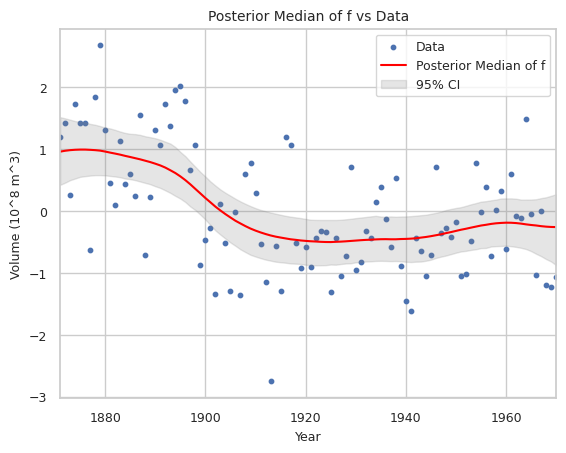

In [38]:
plot_posterior_summary(year, y, mu_hsgp_matern32_sum)

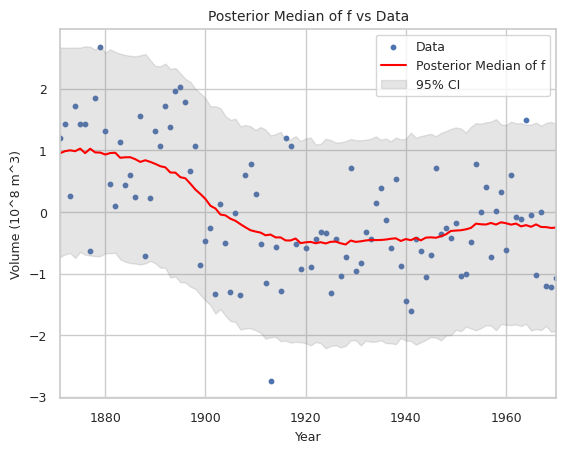

In [39]:
plot_posterior_summary(year, y, y_rep_hsgp_matern32_sum)

Create a new Stan file titled `hsgp_matern52_regression.stan` where the squared exponential covariance kernel is replaced by the Matern 5/2 kernel.

In [42]:
hsgp_matern52_model = CmdStanModel(stan_file='hsgp_matern52_regression.stan')

21:30:02 - cmdstanpy - INFO - compiling stan file /content/hsgp_matern52_regression.stan to exe file /content/hsgp_matern52_regression
INFO:cmdstanpy:compiling stan file /content/hsgp_matern52_regression.stan to exe file /content/hsgp_matern52_regression
DEBUG:cmdstanpy:cmd: make STANCFLAGS+=--filename-in-msg=hsgp_matern52_regression.stan /content/hsgp_matern52_regression
cwd: cmdstan-2.36.0
DEBUG:cmdstanpy:Console output:

--- Translating Stan model to C++ code ---
bin/stanc --filename-in-msg=hsgp_matern52_regression.stan --o=/content/hsgp_matern52_regression.hpp /content/hsgp_matern52_regression.stan

--- Compiling C++ code ---
g++ -std=c++17 -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes -Wno-class-memaccess      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I stan/lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.4.0 -I stan/lib/stan_math/lib/boost_1.84.0 -I stan/lib/stan_math/lib/sundials_6.

In [43]:
hsgp_matern52_fit = hsgp_matern52_model.sample(
	data=stan_data,
	chains=4,
	iter_warmup=500,
	iter_sampling=1000,
	adapt_delta=0.95,
	seed=0
)

DEBUG:cmdstanpy:cmd: /content/hsgp_matern52_regression info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcytd9m2n/p9jh6gv6.json
21:30:48 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/hsgp_matern52_regression', 'id=1', 'random', 'seed=0', 'data', 'file=/tmp/tmpcytd9m2n/p9jh6gv6.json', 'output', 'file=/tmp/tmpcytd9m2n/hsgp_matern52_regression49f8u0im/hsgp_matern52_regression-20250325213048_1.csv', 'method=sample', 'num_samples=1000', 'num_warmup=500', 'algorithm=hmc', 'adapt', 'engaged=1', 'delta=0.95']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/hsgp_matern52_regression', 'id=2', 'random', 'seed=0', 'data', 'file=/tmp/tmpcytd9m2n/p9jh6gv6.json', 'output', 'file=/tmp/tmpcytd9m2n/hsgp_matern52_regression49f8u0im/hsgp_matern52_regression-20250325213048_2.csv', 'method=sample', 'num_samples=1000', 'num_warmup=500', 'algorithm=hmc', 'adapt', 'engaged=1', 'delta=0.95']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/hsgp_matern52_regre

21:31:50 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/hsgp_matern52_regression', 'id=1', 'random', 'seed=0', 'data', 'file=/tmp/tmpcytd9m2n/p9jh6gv6.json', 'output', 'file=/tmp/tmpcytd9m2n/hsgp_matern52_regression49f8u0im/hsgp_matern52_regression-20250325213048_1.csv', 'method=sample', 'num_samples=1000', 'num_warmup=500', 'algorithm=hmc', 'adapt', 'engaged=1', 'delta=0.95']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpcytd9m2n/hsgp_matern52_regression49f8u0im/hsgp_matern52_regression-20250325213048_1.csv
 console_msgs (if any):
	/tmp/tmpcytd9m2n/hsgp_matern52_regression49f8u0im/hsgp_matern52_regression-20250325213048_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 1000 (Default)
    num_warmup = 500
    save_warmup = false (Default)
    thin 

In [44]:
idata_hsgp_matern52 = az.from_cmdstanpy(hsgp_matern52_fit)
mu_hsgp_matern52_sum = az.summary(idata_hsgp_matern52, var_names=['mu'], stat_funcs=custom_summary_fns, extend=False)
y_rep_hsgp_matern52_sum = az.summary(idata_hsgp_matern52, var_names=['y_rep'], stat_funcs=custom_summary_fns, extend=False)

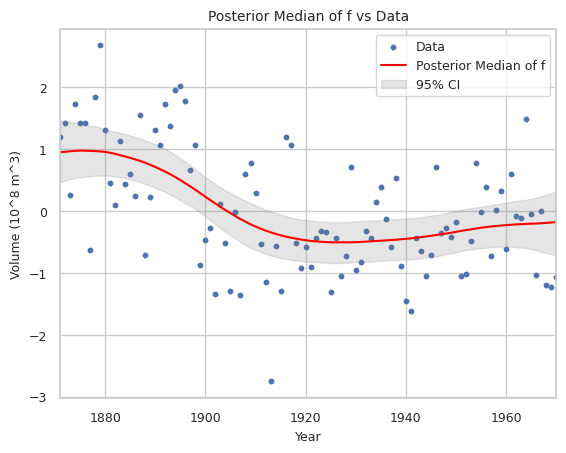

In [45]:
plot_posterior_summary(year, y, mu_hsgp_matern52_sum)

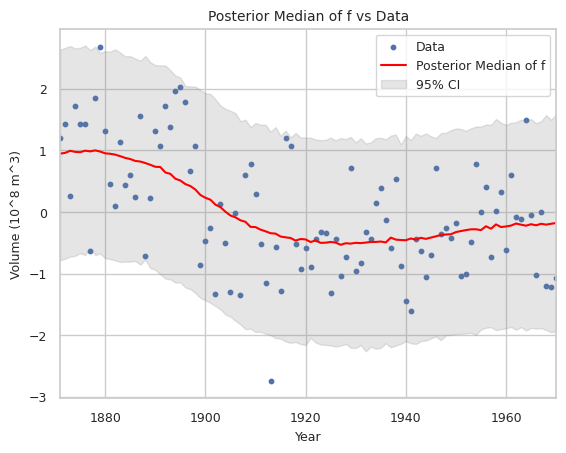

In [46]:
plot_posterior_summary(year, y, y_rep_hsgp_matern52_sum)

## Application of GPs

Did you notice that there seems to a a significant and permanent drop in the flow volume of the Nile river around 1899? This is attributed to several factors low rain fall in the Ethiopian highlands, and the construction of the Aswan Dam in 1902. Modeling the time series of flow volume using a stationary GP is clearly not appropriate in this case. Upon visual examination, it seems that if we split the data around 1899, and fit two separate GPs to the data, we might be able to model the data more appropriately. Let us alter our model to do this.

Let $t = 1, \ldots, T$ be the time index. We will split the data into two parts: $t=1,\ldots,c-1$ and $t=c,\ldots,T$, where $c = 1899$. We will fit a GP to each part of the data. The likelihood for the data is then
$$
\begin{align}
Y_t \sim \begin{cases}
N(\mu_0(t), \sigma_{\varepsilon}^2) & \text{if } t < c, \\
N(\mu_1(t), \sigma_{\varepsilon}^2) & \text{if } t \geq c.
\end{cases}
\end{align}
$$
where
$$
\begin{align}
\mu_0(t) &= \alpha_0 + f_0(t) \\
\mu_1(t) &= \alpha_1 + f_1(t).
\end{align}
$$
We will assign the following priors
$$
\begin{align}
\alpha_0, \alpha_1 &\sim N(0, 1), \\
\sigma_{\varepsilon} &\sim \text{Inv-Gamma}(5, 5) \\
f_0 &\sim \text{HSGP}(0, k_0(t,t';\sigma_0,\ell_0)), \\
f_1 &\sim \text{HSGP}(0, k_1(t,t';\sigma_1,\ell_1)), \\
\sigma_0, \sigma_1 &\sim \text{Inv-Gamma}(5, 5), \\
\ell_0, \ell_1 &\sim \text{Inv-Gamma}(5, 5)
\end{align}
$$

In [ ]:
hsgp_rdd = CmdStanModel(stan_file='hsgp_rdd.stan')

15:44:19 - cmdstanpy - INFO - compiling stan file /Users/shozendan/Imperial/stats_ml_population_health/day2/hands_on_scalable_gp/stan/hsgp_rdd.stan to exe file /Users/shozendan/Imperial/stats_ml_population_health/day2/hands_on_scalable_gp/stan/hsgp_rdd
15:44:52 - cmdstanpy - INFO - compiled model executable: /Users/shozendan/Imperial/stats_ml_population_health/day2/hands_on_scalable_gp/stan/hsgp_rdd


In [ ]:
tid0 = np.where(year < 1899)[0] + 1 # Python is 0-indexed, Stan is 1-indexed
tid1 = np.where(year >= 1899)[0] + 1

In [ ]:
stan_data = {
	'N': len(x),
  'N0': len(tid0),
  'N1': len(tid1),
	't': x,
  'tid0': tid0,
  'tid1': tid1,
	'y': y,
}

In [ ]:
hsgp_rdd_fit = hsgp_rdd.sample(
    data=stan_data,
    chains=4,
    iter_warmup=500,
    iter_sampling=1000,
    adapt_delta=0.95,
    seed=0
)

15:46:58 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

15:47:11 - cmdstanpy - INFO - CmdStan done processing.
15:47:11 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[1] is nan, but must be finite! (in 'hsgp_rdd.stan', line 61, column 2 to column 41)
Consider re-running with show_console=True if the above output is unclear!


15:47:11 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 4 had 1 divergent transitions (0.1%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


In [ ]:
print(hsgp_rdd_fit.diagnose())

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
1 of 1000 (0.10%) transitions ended with a divergence.
These divergent transitions indicate that HMC is not fully able to explore the posterior distribution.
Try increasing adapt delta closer to 1.
If this doesn't remove all divergences, try to reparameterize the model.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Rank-normalized split effective sample size satisfactory for all parameters.

Rank-normalized split R-hat values satisfactory for all parameters.

Processing complete.



In [ ]:
idata_rdd = az.from_cmdstanpy(hsgp_rdd_fit)

In [ ]:
mu0_sum = az.summary(idata_rdd, var_names=['mu0'], stat_funcs=custom_summary_fns, extend=False)
mu1_sum = az.summary(idata_rdd, var_names=['mu1'], stat_funcs=custom_summary_fns, extend=False)

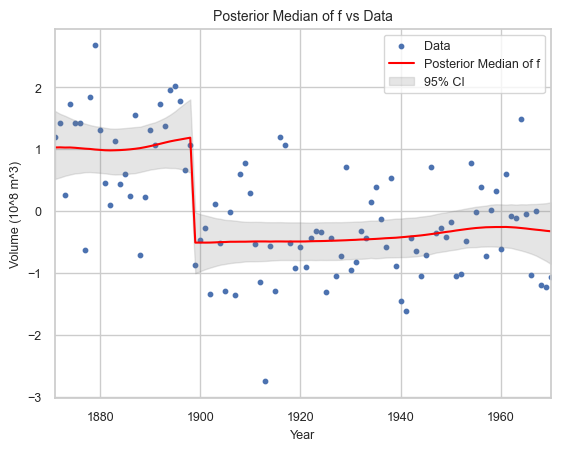

In [ ]:
mu_sum = pd.concat((
    mu0_sum.iloc[tid0 - 1,],
    mu1_sum.iloc[tid1 - 1,]
))

plot_posterior_summary(year, y, mu_sum)

Suppose we wanted to quantify the change in the flow volume of the Nile river around 1899. There is a famous framework in the realm of causal inference called the regression discontinuity design (RDD) that can be used to estimate the causal effect of an intervention. The RDD framework is based on the idea that the treatment effect is discontinuous at the threshold. In our case, the threshold is the year 1899. The goal is to estimate the following quantity
$$
\begin{align}
\tau_{\text{sharp}} &= \lim_{\epsilon \to 0} \left( \mathbb{E}[Y_{c + \epsilon} | t = c + \epsilon] - \mathbb{E}[Y_{c - \epsilon} | t = c - \epsilon] \right) \\
&= \mu_1(c) - \mu_0(c).
\end{align}
$$
Recall that we do not have data for the case where the intervention did not occur at time $t=c$. However, we can use the GP up to timepoint $c-1$ to make predictions for the flow volume at time point $c$ and use that to quantify the difference.

In [ ]:
mu0_flat = idata_rdd.posterior.mu0.stack(sample=('chain', 'draw'))
mu1_flat = idata_rdd.posterior.mu1.stack(sample=('chain', 'draw'))

diff = (mu1_flat[0,:] - mu0_flat[tid1[0],:])
diff = diff * volume_std # Reverse the standardisation to get the difference in volume

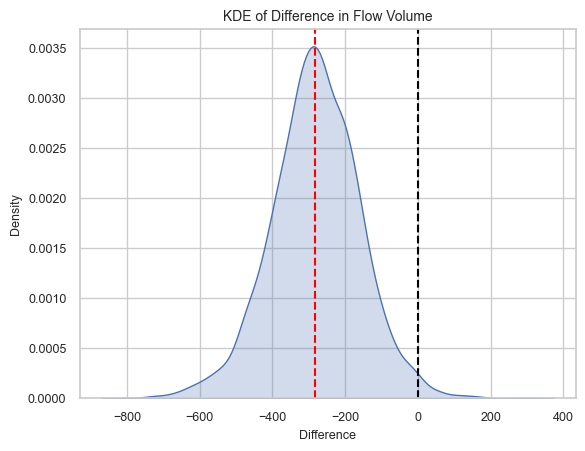

In [ ]:
sns.kdeplot(diff, fill=True)
plt.axvline(0, color='black', linestyle='--')
plt.axvline(diff.mean(), color='red', linestyle='--')
plt.title('KDE of Difference in Flow Volume')
plt.xlabel('Difference')
plt.ylabel('Density')
plt.show()

From the plot above, we can see that the average flow volume decreased by approximately 300 units around 1899. We can also plot the flow volume predictions until 1970 if the intervention did not occur (counter factuals).

/var/folders/fc/szc97hhx4sgg1mzfl9bt0n240000gn/T/ipykernel_40159/1438175866.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.plot(year[tid1-1], mu1_sum['median'][tid1-1], color='red')
/var/folders/fc/szc97hhx4sgg1mzfl9bt0n240000gn/T/ipykernel_40159/1438175866.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.fill_between(year[tid1-1], mu1_sum['q2.5'][tid1-1], mu1_sum['q97.5'][tid1-1], color='red', alpha=0.2)


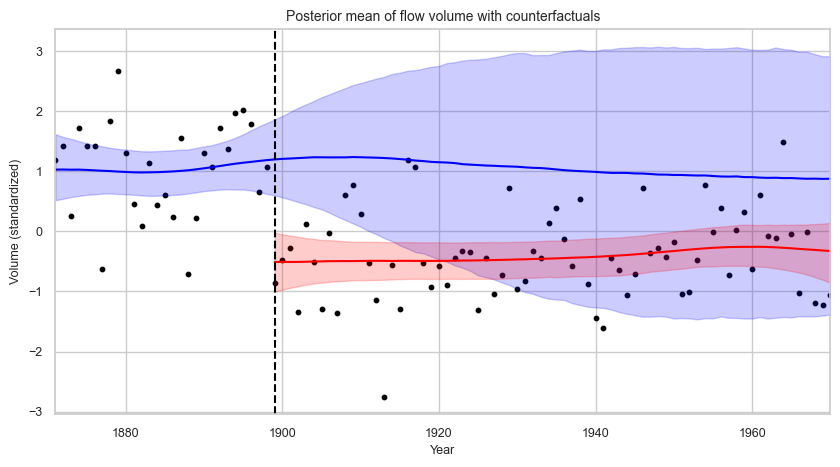

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.scatter(year, y, color='black', label='Data', s=10)
ax.plot(year, mu0_sum['median'], color='blue')
ax.fill_between(year, mu0_sum['q2.5'], mu0_sum['q97.5'], color='blue', alpha=0.2)
ax.plot(year[tid1-1], mu1_sum['median'][tid1-1], color='red')
ax.fill_between(year[tid1-1], mu1_sum['q2.5'][tid1-1], mu1_sum['q97.5'][tid1-1], color='red', alpha=0.2)

ax.axvline(1899, color='black', linestyle='--')
ax.set_xlim(1871, 1970)

ax.set_ylabel('Volume (standardized)')
ax.set_xlabel('Year')
ax.set_title('Posterior mean of flow volume with counterfactuals')

plt.show()

We observe that as we predict more into the future, the uncertainty increases, which is what we would expect.